In [24]:
con.close()

NameError: name 'con' is not defined

Imports and connection

In [25]:
import duckdb
import pandas as pd
import logging
con = duckdb.connect("c:/Code/Local Code/deadlock_match_prediction/data/deadlock.db")

Fetch a set of 1000 matches for a test model training.

In [26]:
match_data = con.execute(f"""
    WITH match_data AS (
        SELECT 
            m.match_id,
            m.start_time,
            m.winning_team
        FROM 
            matches m
        ORDER BY 
            random()  -- Randomly select matches
        LIMIT 1000
    )
    SELECT * FROM match_data""").fetchdf()
print(match_data)

     match_id          start_time winning_team
0    34558495 2025-04-04 03:01:24        Team1
1    34886946 2025-04-15 13:57:24        Team1
2    35255012 2025-04-28 18:44:55        Team0
3    34656657 2025-04-07 05:52:09        Team1
4    34918675 2025-04-16 18:08:15        Team0
..        ...                 ...          ...
995  34292583 2025-03-26 10:59:40        Team1
996  34994001 2025-04-19 09:32:43        Team1
997  35068160 2025-04-21 20:52:26        Team0
998  35112987 2025-04-23 16:21:40        Team0
999  34635283 2025-04-06 15:28:05        Team1

[1000 rows x 3 columns]


Fetch the players from each of the matches

In [27]:
team_of_players = con.execute(f"""
    WITH teams_of_players AS (
        SELECT
            pm.match_id,
            pm.account_id,
            pm.hero_id,
            pm.team,
            pm.kills,
            pm.deaths,
            pm.assists,
            CASE WHEN pm.deaths = 0 THEN pm.kills ELSE CAST(pm.kills AS FLOAT) / pm.deaths END AS kd_ratio
        FROM 
            player_matches pm
        JOIN 
            match_data md ON pm.match_id = md.match_id
    )
SELECT * FROM teams_of_players""").fetchdf()
print(team_of_players)


       match_id  account_id  hero_id   team  kills  deaths  assists  kd_ratio
0      35537307    86596661       18  Team0      3      11       20  0.272727
1      35537307    13446690       58  Team1     12       9       15  1.333333
2      35537307   141857833        8  Team1      7       8        6  0.875000
3      35537307   195016484       10  Team0      5       6       14  0.833333
4      35537307   155395557        6  Team1      4      10       18  0.400000
...         ...         ...      ...    ...    ...     ...      ...       ...
11995  34250251   128001719        3  Team0      6       4        4  1.500000
11996  34250251  1583254751       15  Team1     11       3        5  3.666667
11997  34250251    96459605        1  Team0      5       7        6  0.714286
11998  34250251    94897742        7  Team1      5       4       13  1.250000
11999  34250251   323196641       58  Team0      6       9        4  0.666667

[12000 rows x 8 columns]


Combine normalized match_players into their respective teams and aggreggate some stats for each team.

In [28]:

#-- Calculate team-level statistics
team_stats= con.execute(f"""
    WITH team_stats AS (
        SELECT
            match_id,
            team,
            AVG(kd_ratio) AS team_avg_kd,
            MAX(kd_ratio) AS team_max_kd,
            MIN(kd_ratio) AS team_min_kd,
            COUNT(*) AS team_size
        FROM 
            team_of_players
        GROUP BY 
            match_id, team
    )
    Select * from team_stats""").fetchdf()
print(team_stats)



      match_id   team  team_avg_kd  team_max_kd  team_min_kd  team_size
0     35547056  Team0     1.353968     1.800000     0.571429          6
1     35551802  Team1     0.775137     2.125000     0.000000          6
2     34193516  Team0     0.875000     1.500000     0.100000          6
3     34200355  Team0     0.693386     1.571429     0.200000          6
4     34207547  Team1     3.891667    10.000000     0.600000          6
...        ...    ...          ...          ...          ...        ...
1995  34467669  Team0     0.951389     2.000000     0.250000          6
1996  34367035  Team0     1.107143     3.000000     0.375000          6
1997  34338607  Team1     0.991035     2.000000     0.200000          6
1998  34245658  Team0     2.847222    13.000000     0.250000          6
1999  34248335  Team1     0.711040     1.333333     0.200000          6

[2000 rows x 6 columns]


Combine additional player stats into team-wide stats using averages. Winrate, streaks, KD, and experience include a min, max, and average for the team.

In [29]:
player_performance = con.execute(f"""
    WITH player_performance AS (
        SELECT
            ta.match_id,
            ta.team,
            -- Basic performance stats
            AVG(pt.p_average_kills) AS avg_team_kills,
            AVG(pt.p_average_deaths) AS avg_team_deaths,
            AVG(pt.p_avg_kd) AS avg_team_kd,
            AVG(pt.p_win_rate) AS avg_team_win_rate,
            AVG(pt.p_total_matches) AS avg_player_matches,
            
            -- Streak information
            AVG(pt.p_win_streak_avg) AS avg_win_streak,
            AVG(pt.p_loss_streak_avg) AS avg_loss_streak,
            SUM(pt.win_streaks_2plus) AS team_win_streaks_2plus,
            SUM(pt.win_streaks_3plus) AS team_win_streaks_3plus,
            SUM(pt.win_streaks_4plus) AS team_win_streaks_4plus,
            SUM(pt.win_streaks_5plus) AS team_win_streaks_5plus,
            SUM(pt.loss_streaks_2plus) AS team_loss_streaks_2plus,
            SUM(pt.loss_streaks_3plus) AS team_loss_streaks_3plus,
            SUM(pt.loss_streaks_4plus) AS team_loss_streaks_4plus,
            SUM(pt.loss_streaks_5plus) AS team_loss_streaks_5plus,
            
            
            -- Team strength indicators
            MAX(pt.p_win_rate) AS max_player_win_rate,
            MIN(pt.p_win_rate) AS min_player_win_rate,
            MAX(pt.p_avg_kd) AS max_player_kd,
            MIN(pt.p_avg_kd) AS min_player_kd,
            
            -- Experience metrics
            SUM(pt.p_total_matches) AS total_team_experience,
            MAX(pt.p_total_matches) AS most_experienced_player,
            MIN(pt.p_total_matches) AS least_experienced_player,
            
            -- Consistency metrics
            STDDEV(pt.p_win_rate) AS win_rate_consistency,
            STDDEV(pt.p_avg_kd) AS kd_consistency
        FROM 
            team_of_players ta
        JOIN 
            player_trends pt ON ta.account_id = pt.account_id
        GROUP BY 
            ta.match_id, ta.team
    )
    SELECT * FROM player_performance
    """).fetchdf()
print(player_performance)

      match_id   team  avg_team_kills  avg_team_deaths  avg_team_kd  \
0     34279991  Team1        8.305000         6.516667     1.298333   
1     34275762  Team1        7.718333         6.768333     1.205000   
2     34104453  Team1        6.001667         5.730000     1.086667   
3     35001977  Team1        7.258333         6.280000     1.170000   
4     35197907  Team1       10.235000         5.628333     1.938333   
...        ...    ...             ...              ...          ...   
1995  34332111  Team0        7.865000         6.068333     1.308333   
1996  33867641  Team0        8.481667         6.278333     1.361667   
1997  35279743  Team1        9.064000         6.648000     1.372000   
1998  33958472  Team1        7.988333         6.476667     1.245000   
1999  34701621  Team1        7.293333         6.671667     1.095000   

      avg_team_win_rate  avg_player_matches  avg_win_streak  avg_loss_streak  \
0             54.505000          898.333333        2.362879        

Calculate hero trends from db

In [30]:

#-- Calculate hero trend statistics by team
hero_trend_by_team= con.execute(f"""
    WITH hero_trend_by_team AS (
        SELECT
            ta.match_id,
            ta.team,
            AVG(ht.win_rate) AS avg_hero_win_rate,
            AVG(ht.average_kd) AS avg_hero_kd,
            AVG(ht.pick_rate) AS avg_hero_pick_rate,
            SUM(ht.pick_rate) AS total_hero_popularity,
            MAX(ht.win_rate) AS max_hero_win_rate,
            MIN(ht.win_rate) AS min_hero_win_rate,
            MAX(ht.average_kd) AS max_hero_kd,
            MIN(ht.average_kd) AS min_hero_kd,
            STDDEV(ht.win_rate) AS hero_win_rate_variety,
            STDDEV(ht.average_kd) AS hero_kd_variety
        FROM 
            team_of_players ta
        JOIN 
            hero_trends ht ON ta.hero_id = ht.hero_id
        WHERE 
            ht.trend_window_days = 30  -- Using 30-day trends
        GROUP BY 
            ta.match_id, ta.team
    )
        SELECT * from hero_trend_by_team""").fetchdf()
print(hero_trend_by_team)

      match_id   team  avg_hero_win_rate  avg_hero_kd  avg_hero_pick_rate  \
0     35554485  Team0          49.178334     1.100000            4.015000   
1     35554952  Team1          50.218333     0.985000            3.990000   
2     34207048  Team1          50.340000     1.011667            4.346667   
3     34210756  Team1          47.591667     1.098333            4.226667   
4     34168478  Team0          50.705000     1.065000            4.480000   
...        ...    ...                ...          ...                 ...   
1995  34467669  Team0          49.831667     0.958333            3.635000   
1996  34367035  Team0          50.253333     1.065000            3.758333   
1997  34338607  Team1          48.303333     1.003333            3.678333   
1998  34245658  Team0          50.085000     0.980000            3.975000   
1999  34248335  Team1          50.451667     1.040000            3.435000   

      total_hero_popularity  max_hero_win_rate  min_hero_win_rate  \
0     

Calculate recency trends (where within what streaks is the team?)

In [31]:
#-- Get player trends and statistics
recent_performance= con.execute(f"""
    WITH recent_performance AS (
    SELECT
        ta.match_id,
        ta.team,
        -- Existing rolling win/loss percentages
        AVG(prs.p_win_pct_2) AS avg_recent_win_pct_2,
        AVG(prs.p_win_pct_3) AS avg_recent_win_pct_3,
        AVG(prs.p_win_pct_4) AS avg_recent_win_pct_4,
        AVG(prs.p_win_pct_5) AS avg_recent_win_pct_5,
        AVG(prs.p_loss_pct_2) AS avg_recent_loss_pct_2,
        AVG(prs.p_loss_pct_3) AS avg_recent_loss_pct_3,
        AVG(prs.p_loss_pct_4) AS avg_recent_loss_pct_4,
        AVG(prs.p_loss_pct_5) AS avg_recent_loss_pct_5,
        MAX(prs.p_win_pct_5) AS max_recent_win_pct,
        MIN(prs.p_win_pct_5) AS min_recent_win_pct,
        
        -- Player-hero specific metrics
        AVG(prs.p_v_h_kd_pct) AS avg_hero_kd_percentage,
        AVG(prs.p_v_h_pick_rate) AS avg_hero_pick_percentage,
        AVG(prs.p_h_match_count) AS avg_hero_match_count,
        SUM(prs.p_h_match_count) AS total_hero_experience,
        MAX(prs.p_v_h_kd_pct) AS max_hero_kd_percentage,
        MIN(prs.p_v_h_kd_pct) AS min_hero_kd_percentage,
        STDDEV(prs.p_v_h_kd_pct) AS hero_kd_consistency
    FROM 
        team_of_players ta
    JOIN 
        player_rolling_stats prs ON ta.account_id = prs.account_id AND ta.match_id = prs.match_id
    GROUP BY 
        ta.match_id, ta.team
)
    Select * from recent_performance""").fetchdf()
print(recent_performance)

      match_id   team  avg_recent_win_pct_2  avg_recent_win_pct_3  \
0     34149782  Team1             58.333333             61.110001   
1     33959533  Team1             16.666667             27.776667   
2     33918365  Team0             25.000000             38.889999   
3     34301347  Team1             75.000000             72.221667   
4     34005824  Team0             50.000000             50.000000   
...        ...    ...                   ...                   ...   
1305  34104839  Team0             66.666667             77.778333   
1306  34429382  Team0             58.333333             55.555000   
1307  33976825  Team0             75.000000             77.776667   
1308  34260321  Team1             66.666667             66.669998   
1309  34090782  Team0             83.333333             88.889999   

      avg_recent_win_pct_4  avg_recent_win_pct_5  avg_recent_loss_pct_2  \
0                58.333333             60.000000              41.666667   
1                20.8

Create list of features for each match

In [32]:
team_features = con.execute(f"""
    WITH team_features AS (
    SELECT
        ts.match_id,
        ts.team,
        -- Existing features from team stats
        ts.team_avg_kd,
        ts.team_max_kd,
        ts.team_min_kd,
        
        -- Existing features from player performance
        pp.avg_team_kills,
        pp.avg_team_deaths,
        pp.avg_team_kd,
        pp.avg_team_win_rate,
        pp.max_player_win_rate,
        pp.min_player_win_rate,
        pp.max_player_kd,
        pp.min_player_kd,
        pp.avg_player_matches,
        pp.total_team_experience,
        pp.most_experienced_player,
        pp.least_experienced_player,
        pp.win_rate_consistency,
        pp.kd_consistency,
        pp.avg_win_streak,
        pp.avg_loss_streak,
        pp.team_win_streaks_2plus,
        pp.team_win_streaks_3plus,
        pp.team_win_streaks_4plus,
        pp.team_win_streaks_5plus,
        pp.team_loss_streaks_2plus,
        pp.team_loss_streaks_3plus,
        pp.team_loss_streaks_4plus,
        pp.team_loss_streaks_5plus,
        
        -- Hero trend features
        ht.avg_hero_win_rate,
        ht.avg_hero_kd,
        ht.avg_hero_pick_rate,
        ht.total_hero_popularity,
        ht.max_hero_win_rate,
        ht.min_hero_win_rate,
        ht.max_hero_kd,
        ht.min_hero_kd,
        ht.hero_win_rate_variety,
        ht.hero_kd_variety,
        
        -- Recent performance metrics (traditional)
        COALESCE(rps.avg_recent_win_pct_2, 50) AS avg_recent_win_pct_2,
        COALESCE(rps.avg_recent_win_pct_3, 50) AS avg_recent_win_pct_3,
        COALESCE(rps.avg_recent_win_pct_4, 50) AS avg_recent_win_pct_4,
        COALESCE(rps.avg_recent_win_pct_5, 50) AS avg_recent_win_pct_5,
        COALESCE(rps.avg_recent_loss_pct_2, 50) AS avg_recent_loss_pct_2,
        COALESCE(rps.avg_recent_loss_pct_3, 50) AS avg_recent_loss_pct_3,
        COALESCE(rps.avg_recent_loss_pct_4, 50) AS avg_recent_loss_pct_4,
        COALESCE(rps.avg_recent_loss_pct_5, 50) AS avg_recent_loss_pct_5,
        COALESCE(rps.max_recent_win_pct, 50) AS max_recent_win_pct,
        COALESCE(rps.min_recent_win_pct, 50) AS min_recent_win_pct,
        
        -- NEW: Player-hero specific metrics from rolling stats
        COALESCE(rps.avg_hero_kd_percentage, 0) AS avg_hero_kd_percentage,
        COALESCE(rps.avg_hero_pick_percentage, 0) AS avg_hero_pick_percentage,
        COALESCE(rps.avg_hero_match_count, 0) AS avg_hero_match_count,
        COALESCE(rps.total_hero_experience, 0) AS total_hero_experience,
        COALESCE(rps.max_hero_kd_percentage, 0) AS max_hero_kd_percentage,
        COALESCE(rps.min_hero_kd_percentage, 0) AS min_hero_kd_percentage,
        COALESCE(rps.hero_kd_consistency, 0) AS hero_kd_consistency
    FROM 
        team_stats ts
    LEFT JOIN 
        player_performance pp ON ts.match_id = pp.match_id AND ts.team = pp.team
    LEFT JOIN 
        hero_trend_by_team ht ON ts.match_id = ht.match_id AND ts.team = ht.team
    LEFT JOIN 
        recent_performance rps ON ts.match_id = rps.match_id AND ts.team = rps.team
)SELECT * from team_features""").fetchdf()
print(team_features)


      match_id   team  team_avg_kd  team_max_kd  team_min_kd  avg_team_kills  \
0     34279991  Team1     1.979167     3.333333     0.875000        8.305000   
1     34275762  Team1     3.833333     8.000000     1.000000        7.718333   
2     34104453  Team1     0.975000     1.375000     0.600000        6.001667   
3     34237700  Team0     4.876190    14.000000     0.000000        8.231667   
4     34972139  Team0     1.327363     3.200000     0.272727        8.268333   
...        ...    ...          ...          ...          ...             ...   
1995  35130225  Team1     1.131944     2.666667     0.200000        8.063334   
1996  35651017  Team1     1.277778     2.000000     0.333333        8.535000   
1997  35399414  Team0     1.369444     2.666667     0.300000        7.541667   
1998  35091792  Team1     0.891336     1.285714     0.444444        8.506667   
1999  35247279  Team1     0.465278     1.333333     0.166667        6.925000   

      avg_team_deaths  avg_team_kd  avg

Combine data into dataset for training

In [33]:
training_set = con.execute(f"""
WITH team_features_ordered AS (
    -- Ensure consistent ordering of teams
    SELECT 
        match_id, 
        team,
        -- Current features
        team_avg_kd,
        team_max_kd,
        team_min_kd,
        avg_hero_kd_percentage,
        avg_hero_pick_percentage,
        avg_hero_match_count,
        total_hero_experience,
        max_hero_kd_percentage,
        min_hero_kd_percentage,
        
        -- Additional features from player_trends
        avg_team_win_rate,
        avg_win_streak,
        avg_loss_streak,
        team_win_streaks_2plus,
        team_win_streaks_3plus,
        team_win_streaks_4plus,
        team_win_streaks_5plus,
        team_loss_streaks_2plus,
        team_loss_streaks_3plus,
        team_loss_streaks_4plus,
        team_loss_streaks_5plus,
        
        -- Additional features from rolling stats
        avg_recent_win_pct_2,
        avg_recent_win_pct_3,
        avg_recent_win_pct_4,
        avg_recent_win_pct_5,
        avg_recent_loss_pct_2,
        avg_recent_loss_pct_3,
        avg_recent_loss_pct_4,
        avg_recent_loss_pct_5,
        
        ROW_NUMBER() OVER (PARTITION BY match_id ORDER BY team) AS team_order
    FROM 
        team_features
)

SELECT
    md.match_id,
    md.start_time,
    md.winning_team,
    
    -- Team 0 features (existing)
    t0.team_avg_kd AS t0_avg_kd,
    t0.team_max_kd AS t0_max_kd,
    t0.team_min_kd AS t0_min_kd,
    t0.avg_hero_kd_percentage AS t0_hero_kd_percentage,
    t0.avg_hero_pick_percentage AS t0_hero_pick_percentage,
    t0.avg_hero_match_count AS t0_hero_match_count,
    t0.total_hero_experience AS t0_hero_experience,
    t0.max_hero_kd_percentage AS t0_max_hero_kd_pct,
    t0.min_hero_kd_percentage AS t0_min_hero_kd_pct,
    
    -- Team 0 additional features (previously missing)
    t0.avg_team_win_rate AS t0_win_rate,
    t0.avg_win_streak AS t0_win_streak_avg,
    t0.avg_loss_streak AS t0_loss_streak_avg,
    t0.team_win_streaks_2plus AS t0_win_streaks_2,
    t0.team_win_streaks_3plus AS t0_win_streaks_3,
    t0.team_win_streaks_4plus AS t0_win_streaks_4,
    t0.team_win_streaks_5plus AS t0_win_streaks_5,
    t0.team_loss_streaks_2plus AS t0_loss_streaks_2,
    t0.team_loss_streaks_3plus AS t0_loss_streaks_3,
    t0.team_loss_streaks_4plus AS t0_loss_streaks_4,
    t0.team_loss_streaks_5plus AS t0_loss_streaks_5,
    
    -- Team 0 rolling stats (previously missing)
    t0.avg_recent_win_pct_2 AS t0_win_pct_2,
    t0.avg_recent_win_pct_3 AS t0_win_pct_3,
    t0.avg_recent_win_pct_4 AS t0_win_pct_4,
    t0.avg_recent_win_pct_5 AS t0_win_pct_5,
    t0.avg_recent_loss_pct_2 AS t0_loss_pct_2,
    t0.avg_recent_loss_pct_3 AS t0_loss_pct_3,
    t0.avg_recent_loss_pct_4 AS t0_loss_pct_4,
    t0.avg_recent_loss_pct_5 AS t0_loss_pct_5,
    
    -- Team 1 features (existing)
    t1.team_avg_kd AS t1_avg_kd,
    t1.team_max_kd AS t1_max_kd,
    t1.team_min_kd AS t1_min_kd,
    t1.avg_hero_kd_percentage AS t1_hero_kd_percentage,
    t1.avg_hero_pick_percentage AS t1_hero_pick_percentage,
    t1.avg_hero_match_count AS t1_hero_match_count,
    t1.total_hero_experience AS t1_hero_experience,
    t1.max_hero_kd_percentage AS t1_max_hero_kd_pct,
    t1.min_hero_kd_percentage AS t1_min_hero_kd_pct,
    
    -- Team 1 additional features (previously missing)
    t1.avg_team_win_rate AS t1_win_rate,
    t1.avg_win_streak AS t1_win_streak_avg,
    t1.avg_loss_streak AS t1_loss_streak_avg,
    t1.team_win_streaks_2plus AS t1_win_streaks_2,
    t1.team_win_streaks_3plus AS t1_win_streaks_3,
    t1.team_win_streaks_4plus AS t1_win_streaks_4,
    t1.team_win_streaks_5plus AS t1_win_streaks_5,
    t1.team_loss_streaks_2plus AS t1_loss_streaks_2,
    t1.team_loss_streaks_3plus AS t1_loss_streaks_3,
    t1.team_loss_streaks_4plus AS t1_loss_streaks_4,
    t1.team_loss_streaks_5plus AS t1_loss_streaks_5,
    
    -- Team 1 rolling stats (previously missing)
    t1.avg_recent_win_pct_2 AS t1_win_pct_2,
    t1.avg_recent_win_pct_3 AS t1_win_pct_3,
    t1.avg_recent_win_pct_4 AS t1_win_pct_4,
    t1.avg_recent_win_pct_5 AS t1_win_pct_5,
    t1.avg_recent_loss_pct_2 AS t1_loss_pct_2,
    t1.avg_recent_loss_pct_3 AS t1_loss_pct_3,
    t1.avg_recent_loss_pct_4 AS t1_loss_pct_4,
    t1.avg_recent_loss_pct_5 AS t1_loss_pct_5,
    
    -- Existing differential features
    (t0.team_avg_kd - t1.team_avg_kd) AS kd_diff,
    (t0.avg_hero_kd_percentage - t1.avg_hero_kd_percentage) AS hero_kd_pct_diff,
    
    -- Additional differential features
    (t0.avg_team_win_rate - t1.avg_team_win_rate) AS win_rate_diff,
    (t0.avg_win_streak - t1.avg_win_streak) AS win_streak_diff,
    (t0.avg_loss_streak - t1.avg_loss_streak) AS loss_streak_diff,
    (t0.avg_recent_win_pct_5 - t1.avg_recent_win_pct_5) AS recent_win_pct_diff,
    
    -- Target variable
    CASE WHEN md.winning_team = t0.team THEN 1 ELSE 0 END AS team0_won
FROM 
    match_data md
JOIN 
    team_features_ordered t0 ON md.match_id = t0.match_id AND t0.team_order = 1
JOIN 
    team_features_ordered t1 ON md.match_id = t1.match_id AND t1.team_order = 2""").fetchdf()
print(f"Robust training set has {len(training_set)} rows")
print(training_set)
output_path = "data/final_training_data.csv"
training_set.to_csv(output_path, index=False)

Robust training set has 1000 rows
     match_id          start_time winning_team  t0_avg_kd  t0_max_kd  \
0    33840743 2025-03-12 15:41:24        Team0   1.666667   3.500000   
1    34003930 2025-03-17 11:28:09        Team0   2.198413   5.500000   
2    34105034 2025-03-20 18:27:32        Team0   1.518519   6.250000   
3    34105108 2025-03-20 18:29:57        Team1   0.622825   1.571429   
4    34248029 2025-03-24 22:03:33        Team0   1.864683   2.571429   
..        ...                 ...          ...        ...        ...   
995  35544565 2025-05-09 00:33:27        Team0   2.988889   9.000000   
996  34566907 2025-04-04 13:00:55        Team0   2.955556   8.000000   
997  35631955 2025-05-10 17:28:40        Team1   0.747619   1.500000   
998  34545054 2025-04-03 17:32:51        Team0   3.155556   9.000000   
999  34133564 2025-03-21 17:04:26        Team0   4.750000   8.000000   

     t0_min_kd  t0_hero_kd_percentage  t0_hero_pick_percentage  \
0     0.750000              24.5000

OSError: Cannot save file into a non-existent directory: 'data'

Normalize data 0-1 for model training, prime for loading.

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Corrected data loading function
def load_training_data(file_path="data/final_training_data.csv"):
    """Load and perform initial inspection of training data with accurate feature count"""
    df = pd.read_csv(file_path)
    
    # Get actual feature count (excluding non-feature columns)
    non_feature_cols = ['match_id', 'start_time', 'winning_team', 'team0_won']
    feature_count = df.shape[1] - sum(col in df.columns for col in non_feature_cols)
    
    print(f"Loaded {len(df)} matches with {df.shape[1]} total columns")
    print(f"Feature count: {feature_count} features (excluding metadata and target)")
    
    # List feature categories
    team0_features = [col for col in df.columns if col.startswith('t0_')]
    team1_features = [col for col in df.columns if col.startswith('t1_')]
    diff_features = [col for col in df.columns if col.endswith('_diff')]
    
    print(f"Team 0 features: {len(team0_features)}")
    print(f"Team 1 features: {len(team1_features)}")
    print(f"Differential features: {len(diff_features)}")
    
    # Check some feature examples from each category
    print("\nSample Team 0 features:", team0_features[:5])
    print("Sample Team 1 features:", team1_features[:5])
    print("Sample differential features:", diff_features[:3])
    
    # Check target distribution
    target_dist = df['team0_won'].value_counts(normalize=True)
    print(f"\nTarget distribution: Team0 won {target_dist.get(1, 0):.2%}, Team1 won {target_dist.get(0, 0):.2%}")
    
    return df

# Test the corrected function
training_data = load_training_data()

FileNotFoundError: [Errno 2] No such file or directory: 'data/final_training_data.csv'

Few more transformations before training

In [35]:
def prepare_features(df):
    """Prepare features for model training"""
    # Handle missing values
    for col in df.columns:
        if df[col].isna().sum() > 0:
            if col.startswith(('t0_win_', 't1_win_', 't0_loss_', 't1_loss_')):
                # For streak/win rate columns, use 0 for missing values
                df[col] = df[col].fillna(0)
            else:
                # For other columns, use median
                df[col] = df[col].fillna(df[col].median())
    
    # Create additional calculated features
    # Win rate dominance (nonlinear scaling of win rate difference)
    df['win_rate_dominance'] = np.tanh((df['t0_win_rate'] - df['t1_win_rate']) / 20) 
    
    # Recent momentum (weighted average of recent win percentages)
    df['t0_momentum'] = (2*df['t0_win_pct_2'] + df['t0_win_pct_3'] + df['t0_win_pct_5']) / 4
    df['t1_momentum'] = (2*df['t1_win_pct_2'] + df['t1_win_pct_3'] + df['t1_win_pct_5']) / 4
    df['momentum_diff'] = df['t0_momentum'] - df['t1_momentum']
    
    # Streakiness (ratio of win streaks to total matches)
    df['t0_streakiness'] = (df['t0_win_streaks_2'] + df['t0_loss_streaks_2']) / (df['t0_hero_match_count'] + 1)
    df['t1_streakiness'] = (df['t1_win_streaks_2'] + df['t1_loss_streaks_2']) / (df['t1_hero_match_count'] + 1)
    
    # KD to win rate efficiency 
    df['t0_kd_efficiency'] = df['t0_win_rate'] / (df['t0_avg_kd'] + 0.1)
    df['t1_kd_efficiency'] = df['t1_win_rate'] / (df['t1_avg_kd'] + 0.1)
    
    # Remove non-feature columns
    feature_df = df.drop(['match_id', 'start_time', 'winning_team'], axis=1, errors='ignore')
    
    return feature_df

processed_data = prepare_features(training_data)

NameError: name 'training_data' is not defined

Split 20% of data for training

In [36]:
def split_train_test(df, target_col='team0_won', test_size=0.2):
    """Split data into training and test sets"""
    # Separate features and target
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    
    # Create train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_train_test(processed_data)

NameError: name 'processed_data' is not defined

Create Random Froest model

In [37]:
from fastai.tabular.all import *
from fastai.metrics       import RocAucBinary, Precision, Recall, F1Score
from sklearn.metrics      import roc_auc_score, precision_recall_curve, confusion_matrix

def train_model(learn, epochs=10):
    """Train the model with optimal learning rate and then run threshold analysis"""
    # 1) find LR & train
    learn.lr_find()
    learn.fit_one_cycle(epochs, 1e-2)
    learn.export('models/deadlock_rf_model.pkl')

    # 2) get raw preds & targets
    probs, targets = learn.get_preds()  
    # probs is AFTER sigmoid already (shape [N,1]), targets is 0/1
    probs   = probs[:,0].numpy()
    targets = targets.numpy().astype(int)

    # 3) ROC AUC with sklearn, not RocAucBinary(...)
    auc = roc_auc_score(targets, probs)
    print(f"Validation ROC AUC: {auc:.4f}")

    # 4) Precision–Recall → find best F1 threshold
    prec, rec, th = precision_recall_curve(targets, probs)
    f1_scores   = 2 * prec * rec / (prec + rec + 1e-8)
    best_idx    = f1_scores.argmax()
    best_thresh = th[best_idx]
    print(f"Best F1={f1_scores[best_idx]:.3f} @ threshold={best_thresh:.2f}")

    # 5) Confusion matrix at that threshold
    preds = (probs >= best_thresh).astype(int)
    cm    = confusion_matrix(targets, preds)
    print("Confusion matrix:\n", cm)

    # 6) (Optional) Quick accuracy sweep
    for t in [0.1,0.2,0.3,0.4,0.45,0.5,0.55,0.6,0.7,0.8,0.9]:
        acc = (probs >= t).mean()
        print(f"Thresh {t:.2f}: acc {acc:.3f}")

    return learn


# Usage:
trained_model = train_model(learn, epochs=10)


ZeroDivisionError: integer division or modulo by zero

Make the magic sauce

epoch,train_loss,valid_loss,accuracy,time
0,0.642259,0.427583,0.470000,00:00
1,0.469061,0.203507,0.470000,00:00
2,0.339527,0.261666,0.470000,00:00
3,0.257998,0.137074,0.470000,00:00
4,0.200938,0.119231,0.470000,00:00
5,0.163547,0.114225,0.470000,00:00
6,0.136729,0.114952,0.470000,00:00
7,0.117350,0.117685,0.470000,00:00
8,0.100783,0.110531,0.470000,00:00
9,0.088869,0.111199,0.470000,00:00


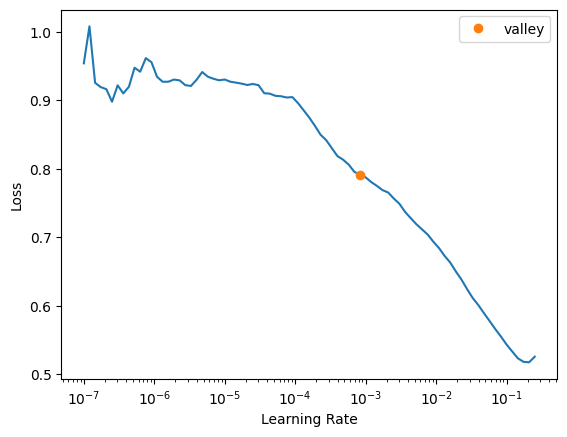

In [24]:
def train_model(learn, epochs=10):
    """Train the model with optimal learning rate"""
    # Find optimal learning rate
    learn.lr_find()
    
    # Train the model
    learn.fit_one_cycle(epochs, 1e-2)
    
    # Save the model
    learn.export('models/deadlock_rf_model.pkl')
    
    return learn

# Train the model
trained_model = train_model(learn)

Investigating anomoly with training % being static

Prediction tensor shape: torch.Size([200, 1])
Model is outputting single values (regression style)

=== Predicted Value Distribution ===
Min: -0.2431
Max: 1.4289
Mean: 0.5341
Median: 0.5642

=== Target Distribution ===
Class 0: 47.00%
Class 1: 53.00%

=== Accuracy with Different Thresholds ===
Threshold 0.10: 0.7050
Threshold 0.20: 0.7950
Threshold 0.30: 0.8250
Threshold 0.40: 0.8550
Threshold 0.45: 0.8600
Threshold 0.50: 0.8550
Threshold 0.55: 0.8450
Threshold 0.60: 0.8250
Threshold 0.70: 0.7800
Threshold 0.80: 0.7400
Threshold 0.90: 0.7000


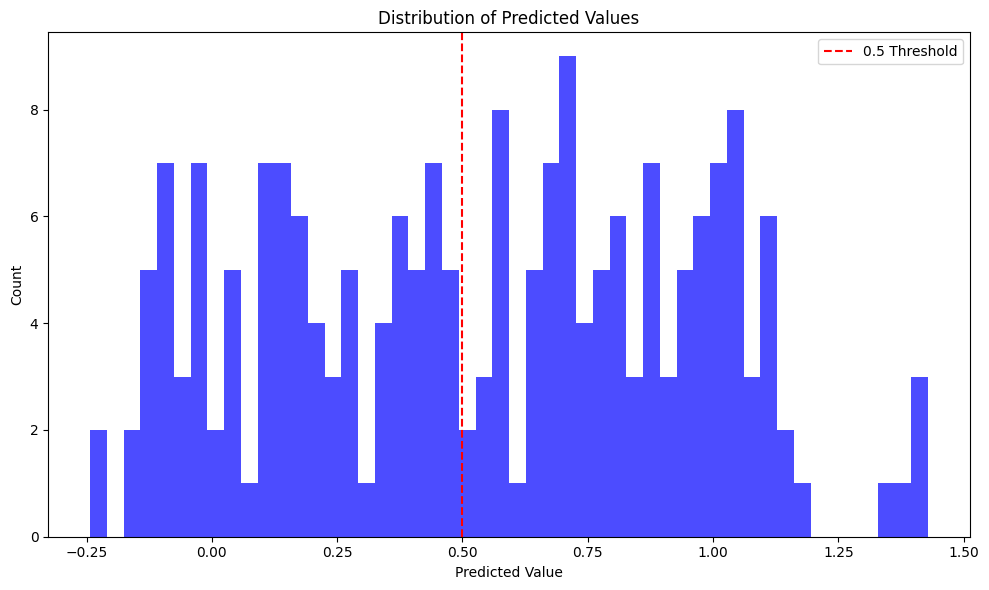

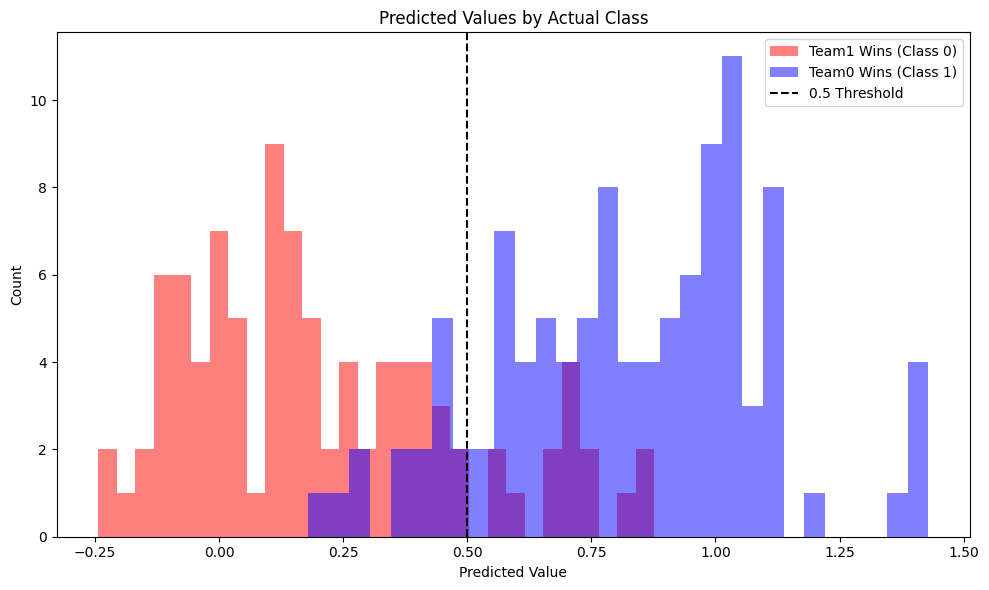

array([ 0.48497903,  0.1078522 ,  1.0465994 ,  0.4698471 ,  1.4281418 ,
        0.29052266,  0.78770125,  0.4596953 , -0.08473771,  0.22290394,
       -0.13320321, -0.01743125,  0.88522416,  1.0663717 ,  0.9814086 ,
        0.5837696 ,  0.48280844,  0.33752912,  0.00878997,  0.15352072,
        1.1006196 ,  1.053524  ,  0.7280408 ,  0.79796714,  0.7715646 ,
        0.8901663 ,  0.20445961,  1.0540483 ,  1.1061001 ,  0.97440743,
        0.81393003,  0.11026002,  0.4571114 ,  0.714795  ,  0.17940947,
        0.72095513, -0.00171462,  0.04365448,  0.92230356,  1.0356593 ,
        0.93962115,  0.4286226 ,  0.3384513 ,  0.9509894 ,  0.6267568 ,
       -0.08365908,  0.25814044,  0.99452025, -0.08550594,  0.41909453,
        0.19361445, -0.1288057 ,  0.84261996,  0.14026722,  0.03509676,
        1.1027014 ,  0.28145134,  0.14438319,  0.13895717,  1.0340346 ,
        0.87672126,  0.17055789,  1.1849213 ,  0.5589173 ,  0.69784653,
        0.77438605,  0.23595613,  0.971259  ,  1.0374414 ,  0.10

In [31]:
def diagnose_static_accuracy(learn, X_test, y_test):
    """Diagnose why accuracy remains static during training"""
    # Get predictions
    test_dl = learn.dls.test_dl(X_test)
    preds, _ = learn.get_preds(dl=test_dl)
    
    # Check shape of predictions
    print(f"Prediction tensor shape: {preds.shape}")
    
    # Handle both regression-style (1 column) and classification-style (2 columns) outputs
    if preds.shape[1] == 1:
        # For regression-style output, just use the raw values
        probabilities = preds[:, 0].numpy()
        print("Model is outputting single values (regression style)")
    else:
        # For classification with 2 classes, use the second column (class 1 probability)
        probabilities = preds[:, 1].numpy()
        print("Model is outputting class probabilities")
    
    # Check distribution of predicted values
    print("\n=== Predicted Value Distribution ===")
    print(f"Min: {probabilities.min():.4f}")
    print(f"Max: {probabilities.max():.4f}")
    print(f"Mean: {probabilities.mean():.4f}")
    print(f"Median: {np.median(probabilities):.4f}")
    
    # Check target distribution
    target_dist = y_test.value_counts(normalize=True)
    print("\n=== Target Distribution ===")
    print(f"Class 0: {target_dist.get(0, 0):.2%}")
    print(f"Class 1: {target_dist.get(1, 0):.2%}")
    
    # Try different thresholds
    print("\n=== Accuracy with Different Thresholds ===")
    for threshold in [0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.8, 0.9]:
        preds_at_threshold = (probabilities > threshold).astype(int)
        acc = (preds_at_threshold == y_test.values).mean()
        print(f"Threshold {threshold:.2f}: {acc:.4f}")
    
    # Create histogram of predicted values
    plt.figure(figsize=(10, 6))
    plt.hist(probabilities, bins=50, alpha=0.7, color='blue')
    plt.axvline(x=0.5, color='red', linestyle='--', label='0.5 Threshold')
    plt.title('Distribution of Predicted Values')
    plt.xlabel('Predicted Value')
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.savefig('predicted_values.png')
    plt.show()
    
    # Plot predictions by actual class
    plt.figure(figsize=(10, 6))
    plt.hist(probabilities[y_test.values == 0], bins=30, alpha=0.5, label='Team1 Wins (Class 0)', color='red')
    plt.hist(probabilities[y_test.values == 1], bins=30, alpha=0.5, label='Team0 Wins (Class 1)', color='blue')
    plt.axvline(x=0.5, color='black', linestyle='--', label='0.5 Threshold')
    plt.title('Predicted Values by Actual Class')
    plt.xlabel('Predicted Value')
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.savefig('predicted_values_by_class.png')
    plt.show()
    
    return probabilities
diagnose_static_accuracy(learn, X_test, y_test)

In [38]:
# %% [code]
from fastai.tabular.all import load_learner
import shap
import torch
import matplotlib.pyplot as plt

# point this at your exported .pkl
model_path = r'C:\Code\Local Code\deadlock_match_prediction\models\deadlock_rf_model.pkl'
learn = load_learner(model_path)

# full list of feature names:
feature_names = learn.dls.x_names
print("Features:", feature_names)

# grab a small background batch to “anchor” SHAP
# (use ~100 rows so it’s fast but representative)
background = learn.dls.valid_ds.xs[:100]

Features: ['t0_avg_kd', 't0_max_kd', 't0_min_kd', 't0_hero_kd_percentage', 't0_hero_pick_percentage', 't0_hero_match_count', 't0_hero_experience', 't0_max_hero_kd_pct', 't0_min_hero_kd_pct', 't0_win_rate', 't0_win_streak_avg', 't0_loss_streak_avg', 't0_win_streaks_2', 't0_win_streaks_3', 't0_win_streaks_4', 't0_win_streaks_5', 't0_loss_streaks_2', 't0_loss_streaks_3', 't0_loss_streaks_4', 't0_loss_streaks_5', 't0_win_pct_2', 't0_win_pct_3', 't0_win_pct_4', 't0_win_pct_5', 't0_loss_pct_2', 't0_loss_pct_3', 't0_loss_pct_4', 't0_loss_pct_5', 't1_avg_kd', 't1_max_kd', 't1_min_kd', 't1_hero_kd_percentage', 't1_hero_pick_percentage', 't1_hero_match_count', 't1_hero_experience', 't1_max_hero_kd_pct', 't1_min_hero_kd_pct', 't1_win_rate', 't1_win_streak_avg', 't1_loss_streak_avg', 't1_win_streaks_2', 't1_win_streaks_3', 't1_win_streaks_4', 't1_win_streaks_5', 't1_loss_streaks_2', 't1_loss_streaks_3', 't1_loss_streaks_4', 't1_loss_streaks_5', 't1_win_pct_2', 't1_win_pct_3', 't1_win_pct_4', 't1_w

c:\Code\Local Code\deadlock_match_prediction\.venv\Lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [39]:
# %% [code]
# full list of feature names:
feature_names = learn.dls.x_names
print("Features:", feature_names)

# grab a small background batch to “anchor” SHAP
# (use ~100 rows so it’s fast but representative)
background = learn.dls.valid_ds.xs[:100]


Features: ['t0_avg_kd', 't0_max_kd', 't0_min_kd', 't0_hero_kd_percentage', 't0_hero_pick_percentage', 't0_hero_match_count', 't0_hero_experience', 't0_max_hero_kd_pct', 't0_min_hero_kd_pct', 't0_win_rate', 't0_win_streak_avg', 't0_loss_streak_avg', 't0_win_streaks_2', 't0_win_streaks_3', 't0_win_streaks_4', 't0_win_streaks_5', 't0_loss_streaks_2', 't0_loss_streaks_3', 't0_loss_streaks_4', 't0_loss_streaks_5', 't0_win_pct_2', 't0_win_pct_3', 't0_win_pct_4', 't0_win_pct_5', 't0_loss_pct_2', 't0_loss_pct_3', 't0_loss_pct_4', 't0_loss_pct_5', 't1_avg_kd', 't1_max_kd', 't1_min_kd', 't1_hero_kd_percentage', 't1_hero_pick_percentage', 't1_hero_match_count', 't1_hero_experience', 't1_max_hero_kd_pct', 't1_min_hero_kd_pct', 't1_win_rate', 't1_win_streak_avg', 't1_loss_streak_avg', 't1_win_streaks_2', 't1_win_streaks_3', 't1_win_streaks_4', 't1_win_streaks_5', 't1_loss_streaks_2', 't1_loss_streaks_3', 't1_loss_streaks_4', 't1_loss_streaks_5', 't1_win_pct_2', 't1_win_pct_3', 't1_win_pct_4', 't1_w

In [41]:
# %% [code]
import shap
import torch

# 1) Wrap your PyTorch model in a predict function
def predict_fn(x_array):
    """
    x_array: numpy array of shape (n_samples, n_features)
    Returns: numpy array of predicted probabilities
    """
    t = torch.tensor(x_array, dtype=torch.float32)
    raw = learn.model(t)                   # raw logits
    return torch.sigmoid(raw).numpy().flatten()

# 2) Instantiate KernelExplainer
explainer = shap.KernelExplainer(predict_fn, background)

# 3) Compute SHAP values on your test samples
#    (background and test_samples already defined earlier)
shap_values = explainer.shap_values(test_samples)

# 4) Plot global feature importances (bar chart)
shap.summary_plot(
    shap_values,
    test_samples,
    feature_names=feature_names,
    plot_type='bar'
)


Provided model function fails when applied to the provided data set.


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.